In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from tqdm import tqdm
from torch import Tensor,deg2rad,sin,asin,cos,sqrt,min,max#
from torch.utils.data import DataLoader

In [ ]:
auto=pd.read_csv('/content/drive/MyDrive/new_autograd')
heuristic=pd.read_csv('/content/drive/MyDrive/new_heuristic.csv')
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv')

In [ ]:
heuristic.columns=auto.columns
auto['source']='auto'
heuristic['source']='heuristic'
all_data=pd.concat([auto,heuristic])
all_data.rename(columns={'end_time':'exec_time(s)'},inplace=True)
all_data.reset_index(inplace=True,drop=True)

In [ ]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util,core_load,source
0,10,12,0,17,11,14,20,3,6,9,508.972318,22.8,0.0,auto
1,2,1,16,13,9,2,5,16,20,9,508.972318,22.8,0.0,auto
2,10,18,14,13,5,10,18,14,13,5,508.972318,22.8,0.0,auto
3,18,11,0,16,20,4,9,1,15,20,508.972318,22.8,0.0,auto
4,20,16,3,11,10,20,17,1,9,10,508.972318,22.8,0.0,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,6,17,11,19,9,0,3,8,13,6,4753.791461,18.9,0.0,heuristic
906,9,12,10,0,8,0,9,3,13,17,4753.791461,18.9,0.0,heuristic
907,3,18,16,12,6,20,9,15,3,5,4753.791461,18.9,0.0,heuristic
908,12,16,3,19,1,6,0,8,2,1,4753.791461,18.9,0.0,heuristic


In [ ]:
all_data['total_cpu_usage']=all_data['exec_time(s)']*all_data.avg_cpu_util

In [ ]:
 #reading from the raw Csv
pos_tensors=Tensor(pos_data[['Lat','Lon']].values)

In [ ]:
def haversine(loc1, loc2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      lat1=loc1[:,0]
      lon1=loc1[:,1]
      lat2=loc2[0]
      lon2=loc2[1]
      dLat = deg2rad(lat2 - lat1)# CONVERTING DEGREES TO RADIANS
      dLon = deg2rad(lon2 - lon1)
      lat1 = deg2rad(lat1)
      lat2 = deg2rad(lat2)
      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))
      return R * c # RETURNS THE HAVERSINE DISTANCE

In [ ]:
def maxn2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,5):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = min(min_dists, dists)
  return min_dists.max()
# THE SECOND OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MEAN OF THE MINIMUM NODE TO CONTROLLER LATENCY
def mean2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,5):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = min(min_dists, dists)
    return min_dists.mean()
# THE THIRD OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS MAXIMUM INTERCONTROLLER LATENCY
def maxC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  max_dists = dists
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i])
    max_dists = max(max_dists, dists)
  return max_dists.max()
# THE FOURTH OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS DIVISION OF THE SUM OF INTERCONTROLLER LATENCY BY 5C2
def meanC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  sum_dists = dists.sum()
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i]).sum()
    sum_dists = sum_dists+ dists
  return sum_dists/20
def all_losses(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  return np.array([l1,l2,l3,l4])

In [ ]:
inp_cols=all_data.columns[:5]
out_cols=all_data.columns[5:10]
losses=['maxn2C','mean2C','maxC2C','meanC2C']
inp_losses_cols=['inp_'+col for col in losses ]
out_losses_cols=['out_'+col for col in losses ]

In [ ]:
for row in tqdm(range(all_data.shape[0])):
  inp_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[inp_cols].values[row]])
  out_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[out_cols].values[row]])
  all_data.loc[row,inp_losses_cols]=all_losses(pos_tensors,inp_cont_locs)
  all_data.loc[row,out_losses_cols]=all_losses(pos_tensors,out_cont_locs)

100%|██████████| 910/910 [00:11<00:00, 76.41it/s]


In [ ]:
diff_losses=['diff_'+col[4:] for col in inp_losses_cols]
all_data[diff_losses]=all_data[inp_losses_cols].values-all_data[out_losses_cols].values

In [ ]:
all_data['inp_total_loss']=0
for col in inp_losses_cols:
  all_data['inp_total_loss']=all_data['inp_total_loss']+all_data[col]
all_data['out_total_loss']=0
for col in out_losses_cols:
  all_data['out_total_loss']=all_data['out_total_loss']+all_data[col]
all_data['diff_loss']=all_data['inp_total_loss']-all_data['out_total_loss']

In [ ]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,...,out_mean2C,out_maxC2C,out_meanC2C,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,inp_total_loss,out_total_loss,diff_loss
0,10,12,0,17,11,14,20,3,6,9,...,363.119019,1207.625732,694.753296,56.936066,123.031586,624.815796,373.535522,3935.601593,2757.282623,1178.318970
1,2,1,16,13,9,2,5,16,20,9,...,388.167084,1207.625732,681.572144,56.936066,63.548645,-114.108887,-22.183289,2753.342072,2769.149536,-15.807465
2,10,18,14,13,5,10,18,14,13,5,...,381.883667,833.735413,439.408203,0.000000,0.000000,0.000000,0.000000,2324.764954,2324.764954,0.000000
3,18,11,0,16,20,4,9,1,15,20,...,362.260712,1207.625732,625.666382,0.000000,10.733734,174.627197,205.263794,3077.962128,2687.337402,390.624725
4,20,16,3,11,10,20,17,1,9,10,...,471.168457,1207.625732,763.587646,0.000000,-66.728912,174.627197,64.437134,3106.501831,2934.166412,172.335419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,6,17,11,19,9,0,3,8,13,6,...,594.459045,720.926086,449.398529,163.094238,-205.897217,199.894165,224.347504,2916.303833,2534.865143,381.438690
906,9,12,10,0,8,0,9,3,13,17,...,542.419922,1177.827271,807.490540,0.000000,44.908447,440.390503,143.605774,3705.363098,3076.458374,628.904724
907,3,18,16,12,6,20,9,15,3,5,...,492.808594,1207.625732,683.699402,283.286469,-147.576141,-10.495239,43.615234,3044.748627,2875.918304,168.830322
908,12,16,3,19,1,6,0,8,2,1,...,431.673706,490.136810,302.064514,-5.164124,18.728027,706.993683,412.067322,3165.555176,2032.930267,1132.624908


In [ ]:
means=all_data.groupby('source').mean().reset_index()
means

,source,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,...,out_mean2C,out_maxC2C,out_meanC2C,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,inp_total_loss,out_total_loss,diff_loss
0,auto,10.391209,10.336264,10.232967,10.215385,9.839560,10.347253,10.189011,10.843956,10.597802,...,378.154682,954.815886,558.495526,99.158452,41.333871,123.832253,50.518479,2854.888519,2540.045463,314.843056
1,heuristic,9.184615,9.032967,9.936264,8.951648,9.375824,7.375824,3.413187,7.419780,6.138462,...,476.678838,844.084207,501.745658,28.287475,-65.030179,191.726904,86.633647,2826.140169,2584.522321,241.617848


In [ ]:
N2c_cols=[col for col in all_data.columns if col.endswith('n2C')]
means[N2c_cols]

,inp_maxn2C,inp_mean2C,out_maxn2C,out_mean2C,diff_maxn2C,diff_mean2C
0,747.737820,419.488553,648.579369,378.154682,99.158452,41.333871
1,790.301094,411.648659,762.013619,476.678838,28.287475,-65.030179


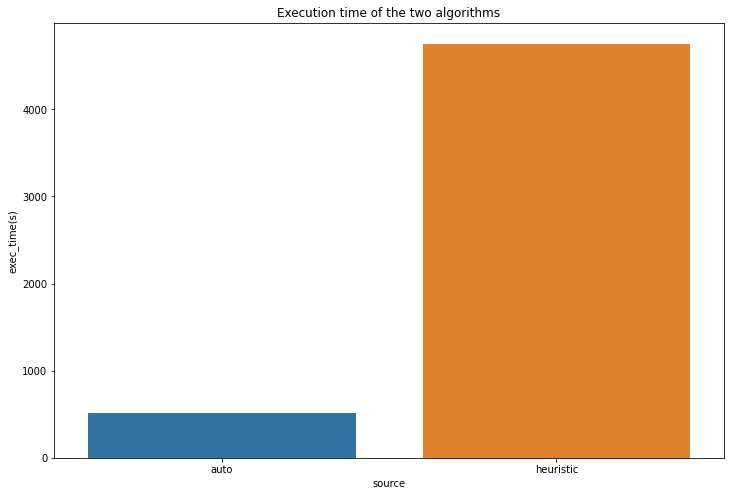

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='source',y='exec_time(s)')
plt.title('Execution time of the two algorithms')
plt.show()

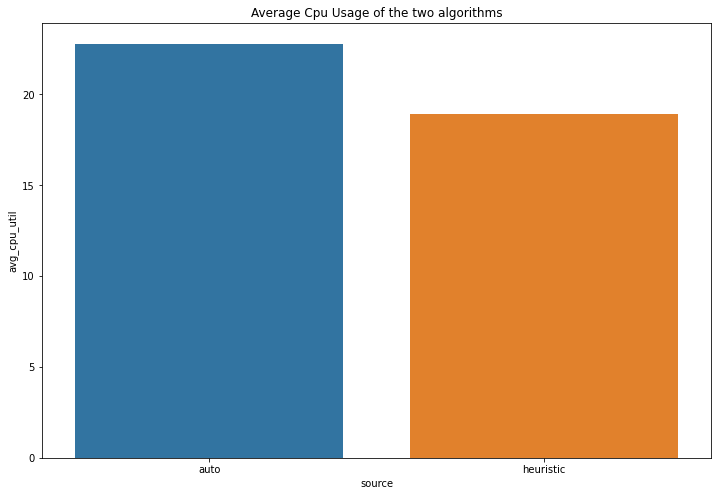

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='source',y='avg_cpu_util')
plt.title('Average Cpu Usage of the two algorithms')
plt.show()

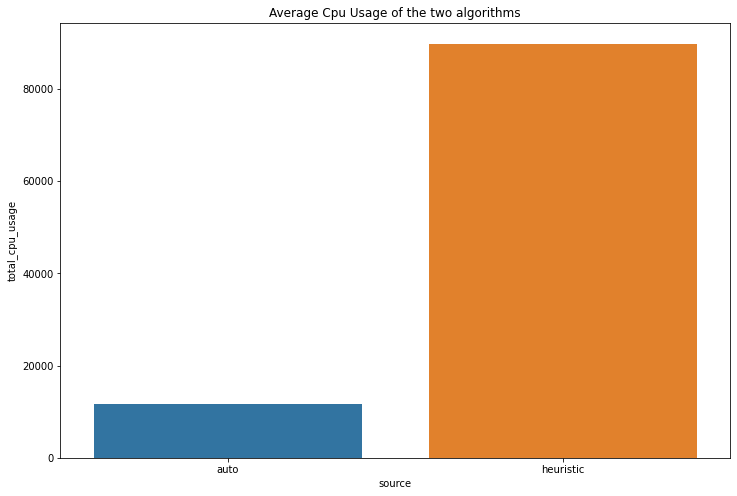

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='source',y='total_cpu_usage')
plt.title('Average Cpu Usage of the two algorithms')
plt.show()

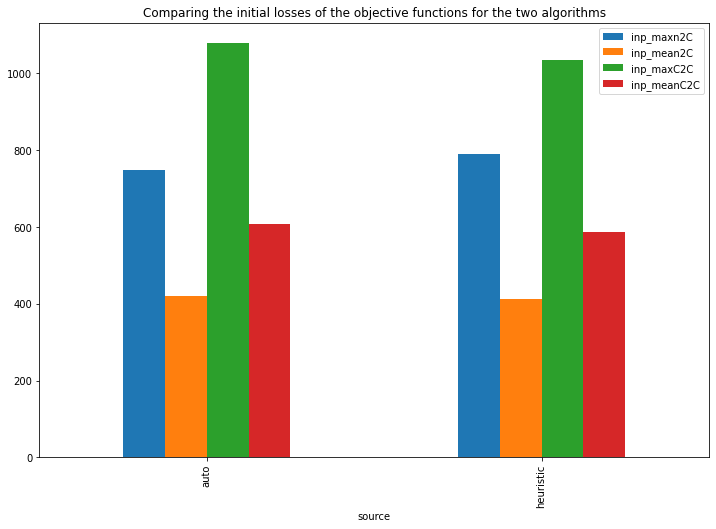

In [ ]:
means.plot(y=inp_losses_cols,x='source',kind='bar',figsize=(12,8))
plt.title('Comparing the initial losses of the objective functions for the two algorithms')
plt.show()

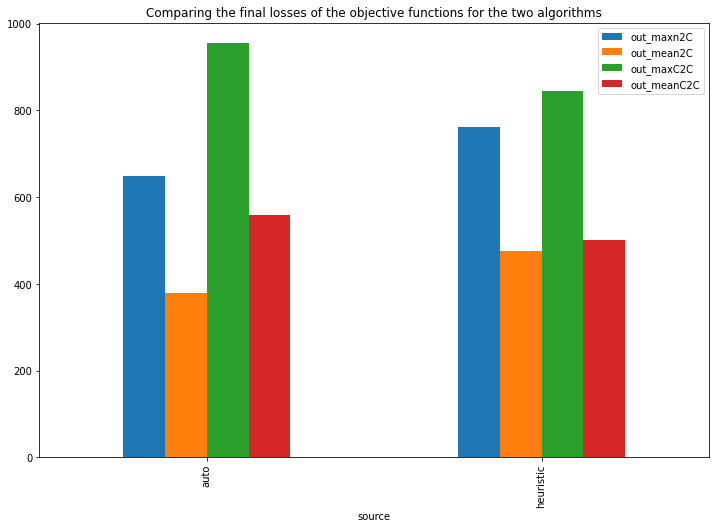

In [ ]:
means.plot(y=out_losses_cols,x='source',kind='bar',figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the two algorithms')
plt.show()

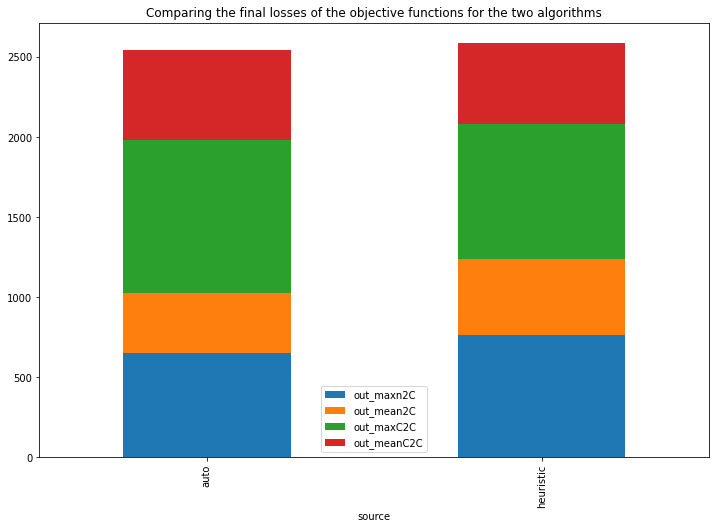

In [ ]:
means.plot(y=out_losses_cols,x='source',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the two algorithms')
plt.show()

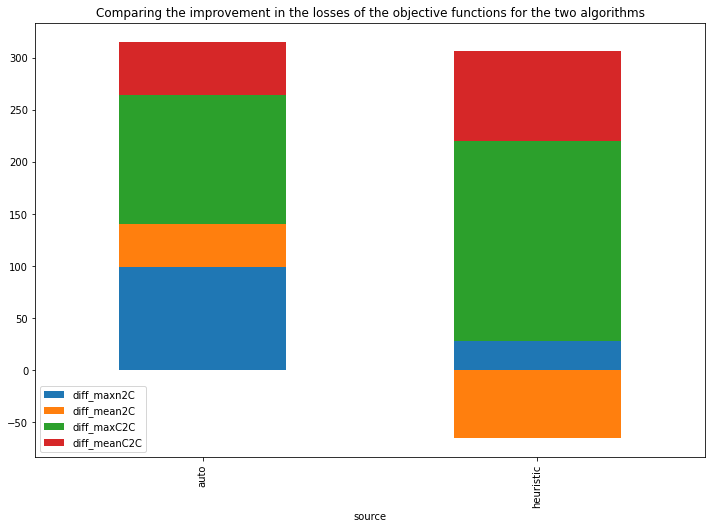

In [ ]:
means.plot(y=diff_losses,x='source',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the improvement in the losses of the objective functions for the two algorithms')
plt.show()

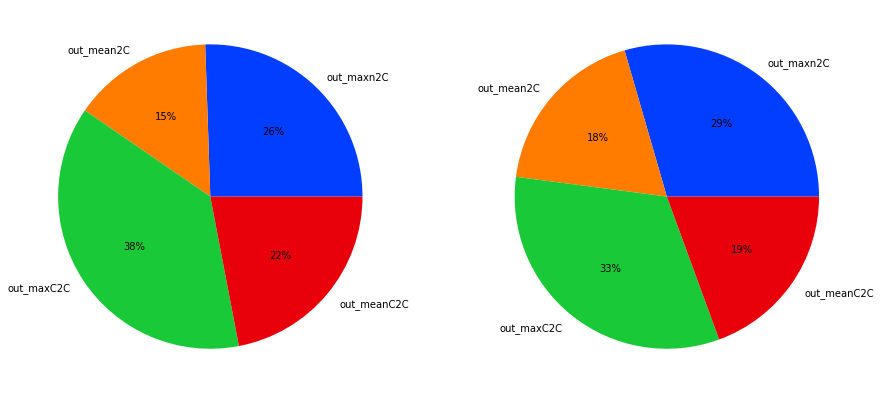

In [ ]:
palette_color = sns.color_palette('bright')
fig, ax = plt.subplots(1, 2,figsize=(15, 7)) 
ax[0].pie(means.loc[0,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
ax[1].pie(means.loc[1,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
plt.show()